# Fake news prediction with CNN

In [1]:
import pandas as pd
import numpy as np
import csv
import re
import matplotlib.pyplot as plt
import seaborn as sns

from gensim.utils import simple_preprocess
from gensim.corpora import Dictionary

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# try to run on GPU is possible
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

cuda


## Prepare data

In [0]:
TOTAL_NUM_ROWS = 80000 # total number og articles used from dataset

# load fake news dataset
def load():
    filepath = '/content/drive/My Drive/1mio-clean.csv'
    df = pd.read_csv(filepath,usecols=[3,5])
    df = df.dropna()
    df = df.drop_duplicates()
    # map to binary labels:
    df['b_type'] = df['type'].apply(lambda x: 'FAKE' if x in ['fake','satire','bias',
                                                              'conspiracy','junksci'] else 'REAL')
    
    # split the dataset with same state as earlier, then return a concatenation of a subset of each split
    train, test = train_test_split(df, test_size=0.2, random_state=1)

    return pd.concat([train.sample(int(TOTAL_NUM_ROWS*0.8)), test.sample(int(TOTAL_NUM_ROWS*0.2))])
df = load()

In [4]:
# load glove embedding with vector dim = 100
EMBEDDING_DIM = 100

def create_embeddings_index():
    words_df = pd.read_csv('/content/drive/My Drive/glove.6B.100d.txt', sep=" ", index_col=0, na_values=None,
                         keep_default_na=False, header=None, quoting=csv.QUOTE_NONE)
    return {word: words_df.loc[word].values for word in list(words_df.index.values)}
embeddings_index = create_embeddings_index()
print('number of vectors:',len(embeddings_index))

number of vectors: 400000


In [5]:
# tokenize texts with gensim
tokenized_texts = list()
for text in df.content:
    tokenized_texts.append(simple_preprocess(text, min_len=0))

MAX_NUM_WORDS = 10000 # maximum number of words used for the model
MAX_TEXT_LENGTH = 1000 # maximum number of length (in words) of each article
    
# map word to id
dictionary = Dictionary(tokenized_texts)
dictionary.filter_extremes(no_below=0, no_above=1.0, keep_n=MAX_NUM_WORDS-2)

word_index = dictionary.token2id

print('Number of tokens:',len(word_index))
print('tokenized_texts first 10 words in first text:',tokenized_texts[0][:10])
print('word_index of "the":',word_index['the'])

Number of tokens: 9998
tokenized_texts first 10 words in first text: ['complete', 'ppp', 'report', 'on', 'their', 'recent', 'polling', 'for', 'arizona', 'can']
word_index of "the": 237


In [6]:
# convert words in tokenized texts to integer id
data = [dictionary.doc2idx(text) for text in tokenized_texts]

# truncate and pad each text
data = [text[:MAX_TEXT_LENGTH] for text in data]
data = np.array([np.pad(text, (0, MAX_TEXT_LENGTH-len(text)), mode='constant',
                        constant_values=-2) for text in data], dtype=int)

# add 2 so padding is 0 and unknown words is 1
data = data + 2 

print('Shape of data tensor:',data.shape)
print('Length of label vector:',len(df.b_type))

Shape of data tensor: (80000, 1000)
Length of label vector: 80000


In [7]:
# create embeding matrix
# for words chosen in words_index use corresponding vector in glove if exsist

embedding_matrix = np.zeros((MAX_NUM_WORDS,EMBEDDING_DIM))
words_not_found = [] # number of words not found in glove

for word,i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i+2] = embedding_vector
    else:
        words_not_found += [word]
        
embedding_matrix = torch.FloatTensor(embedding_matrix)  
print('Shape of embedding matrix:',embedding_matrix.shape)
print('Number of words not found in glove:',len(words_not_found))
print(words_not_found[:10])

Shape of embedding matrix: torch.Size([10000, 100])
Number of words not found in glove: 73
['blockchain', 'lifesitenews', 'kossacks', 'investwatchblog', 'iwb', 'realdonaldtrump', 'naturalnews', 'hadn', 'amembassy', 'ciae']


it is seen that 'blockchain' is not included in GloVe, which is important for the LinearSVC

In [8]:
# convert FAKE to 1 and REAL to 0
_y = list(df.b_type.apply(lambda x: 1 if x=='FAKE' else 0))

# split into train and test as earlier, then split the train into train and validation
x_train, x_test, y_train, y_test = data[:int(TOTAL_NUM_ROWS*0.8)], data[int(TOTAL_NUM_ROWS*0.8):], _y[:int(TOTAL_NUM_ROWS*0.8)], _y[int(TOTAL_NUM_ROWS*0.8):]
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=int(len(df)/10))
print('train:',len(x_train),'  val:',len(x_val),'  test:',len(x_test))

train: 56000   val: 8000   test: 16000


In [0]:
# prepare the data for the network
batch_size = 128
train_dataset = TensorDataset(torch.LongTensor(x_train),
                             torch.LongTensor(y_train))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

val_dataset = TensorDataset(torch.LongTensor(x_val),
                             torch.LongTensor(y_val))
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

test_dataset = TensorDataset(torch.LongTensor(x_test),
                             torch.LongTensor(y_test))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

In [0]:
out_channels = 100
kernel_sizes = [3, 4, 5]
dropout = 0.5

## The model

In [11]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.embed = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)
        
        self.convs = nn.ModuleList([nn.Conv2d(1, out_channels, (size, EMBEDDING_DIM)) for size in kernel_sizes])
        
        self.pools = nn.ModuleList([nn.MaxPool2d((MAX_TEXT_LENGTH+1-size, 1)) for size in kernel_sizes])
        
        self.dropout = nn.Dropout(dropout)
        
        self.fc = nn.Linear(out_channels*len(kernel_sizes), 2)
        
    def forward(self, x):

        # (batch_size, text_length, embedding_dim)
        x = self.embed(x)
        
        # (batch_size, 1, text_length, embedding_dim)
        x = x.unsqueeze(1)
        
        # convolution and pool layer for each kernel size
        # each (batch_size, out_channels, 1, 1)
        x = [pool(F.relu(conv(x))) for conv,pool in zip(self.convs, self.pools)]
        
        # (batch_size, outchannels*len(kernel_sizes), 1, 1)
        x = torch.cat(x, dim=1)
        
        # (batch_size, outchannels*len(kernel_sizes))
        x = x.view(x.size(0), -1)
        
        x = self.dropout(x)
        
        # (batch_size, n_classes)
        x = self.fc(x)
        
        return F.softmax(x, dim=1)
        
model = CNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

print(model)

CNN(
  (embed): Embedding(10000, 100)
  (convs): ModuleList(
    (0): Conv2d(1, 100, kernel_size=(3, 100), stride=(1, 1))
    (1): Conv2d(1, 100, kernel_size=(4, 100), stride=(1, 1))
    (2): Conv2d(1, 100, kernel_size=(5, 100), stride=(1, 1))
  )
  (pools): ModuleList(
    (0): MaxPool2d(kernel_size=(998, 1), stride=(998, 1), padding=0, dilation=1, ceil_mode=False)
    (1): MaxPool2d(kernel_size=(997, 1), stride=(997, 1), padding=0, dilation=1, ceil_mode=False)
    (2): MaxPool2d(kernel_size=(996, 1), stride=(996, 1), padding=0, dilation=1, ceil_mode=False)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=300, out_features=2, bias=True)
)


In [0]:
# function to train the model and return the loss
def train(epoch, model, optimizer, criterion):
    model.train()
    epoch_loss = 0
    
    for x, y in train_loader:
        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
        
        output = model(x)

        loss = criterion(output, y)
        epoch_loss += loss.data.item()
        
        loss.backward()
        
        optimizer.step()
        
    epoch_loss /= len(train_loader)
    print(f'Train Epoch: {epoch}, Loss: {epoch_loss}')
    return [epoch_loss]

# function for validation, returns the loss
def validate(epoch, model, criterion):
    with torch.no_grad():
        correct = 0
        epoch_loss = 0

        model.eval()

        for x, y in val_loader:

            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)

            loss = criterion(y_pred, y)
            epoch_loss += loss.data.item()

            y_pred = torch.max(y_pred, 1)[1]
            correct += (y==y_pred).sum().item()

        epoch_loss /= len(val_loader)
        print(f'Validation Epoch: {epoch}, Loss: {epoch_loss}')
        print('Score:',correct/len(y_val),'\n')

        return [epoch_loss]

# evaluation of test set, accuracy, precision, recall and f1-score is printet
def eval_test(model):
    with torch.no_grad():
        print('Test set:')
        tp = 0
        tn = 0
        fp = 0
        fn = 0

        model.eval()

        for x,y in test_loader:
            x = x.to(device)
            y = y.to(device)

            y_pred = torch.max(model(x),1)[1]

            for i,elm in enumerate(y_pred):
                if y[i] == 1:
                    if elm == 1: tp += 1
                    else: fn += 1
                else:
                    if elm == 0: tn += 1
                    else: fp += 1

        precision = tp/(tp+fp)
        recall = tp/(tp+fn)
        print('Accuracy:',(tp+tn)/len(y_test))
        print('Precison:',precision)
        print('Recall:',recall)
        print('F1-score:',2*(precision*recall)/(precision+recall))

# plotting the learning curve based on loss
def plot_learning_curve(title, loss_train, loss_val):
    ax = sns.lineplot(list(range(1,1+epochs)), loss_train, color='C0')
    ax= sns.lineplot(list(range(1,1+epochs)), loss_val, color='C1')
    ax.set_title(title)
    ax.legend(['train','validation'])
    ax.set_ylabel('loss')
    ax.set_xlabel('epochs')

In [13]:
# train and validate
epochs = 5
loss_train = []
loss_val = []
for epoch in range(1, epochs+1):
    loss_train += train(epoch, model, optimizer, criterion)
    loss_val += validate(epoch, model, criterion)

Train Epoch: 1, Loss: 0.5107744124518138
Validation Epoch: 1, Loss: 0.4681214245538863
Score: 0.8385 

Train Epoch: 2, Loss: 0.45516450090767585
Validation Epoch: 2, Loss: 0.45385943518744576
Score: 0.850375 

Train Epoch: 3, Loss: 0.434093070833106
Validation Epoch: 3, Loss: 0.446579136545696
Score: 0.858125 

Train Epoch: 4, Loss: 0.42000738351040234
Validation Epoch: 4, Loss: 0.44327900286704774
Score: 0.860625 

Train Epoch: 5, Loss: 0.40685777468224094
Validation Epoch: 5, Loss: 0.4446796372769371
Score: 0.859875 



Test set:
Accuracy: 0.8621875
Precison: 0.9197764012690739
Recall: 0.7843339345529503
F1-score: 0.8466726931367777


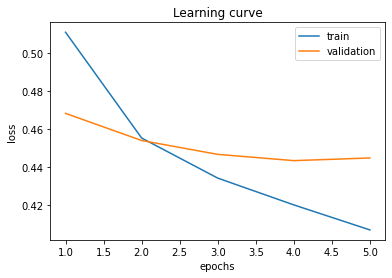

In [14]:
# learning curve and evaluation on test set from own data set
plot_learning_curve('Learning curve', loss_train, loss_val)

eval_test(model)

## Testing on liar dataset

In [0]:
# function to clean content field
def clean_content(text):

    # regular expression for dates
    def re_date():
        re_numdate = r'(?:\d{1,4}(?:\/\d{1,2}\/|-\d{1,2}-)\d{1,4})'
        re_day = r'(?:\d{1,2}(?:th|st|nd|rd|\.)?)'
        re_month = r'(?:jan(?:uary|\.)?|feb(?:ruary|\.)?|mar(?:ch|\.)?|apr(?:il|\.)?|may\.?|jun(?:e|\.)?' \
                   r'|jul(?:y|\.)?|aug(?:ust|\.)?|sept?(?:ember|\.)?|oct(?:ober|\.)?|nov(?:ember|\.)?' \
                   r'|dec(?:ember|\.)?)'
        re_year = r'(?:[, ]*\d{4})?'
        reg = r'(' + re_numdate + \
              r'|(?:' + re_month + r'[, ]*' + re_day + re_year + r')' \
              r'|(?:(?:the)? ?' + re_day + r' (?:of)? ?' + re_month + re_year + r'))'   
        return re.compile(reg)
    
    if pd.notnull(text):
        re_whitespace = re.compile(r"(\s+)")
        re_urls = re.compile(r"(?<=\s)((?:https?://)?\w+(?:\.?\w)*\.(?:com|org|net|dk)(?:\/[\w/?.#=\-+%]*)?)")
        re_email = re.compile(r"(?<=\s)(\w(?:\.?[\w+\-])*@\w(?:[.\-]?\w)*)")
        re_date = re_date()
        re_num = re.compile(r"(\d+(?:,\d{3})*(?:\.\d+)?)")

        text = re_whitespace.sub(' ',text)
        text = text.lower()
        text = re_urls.sub('<URL>',text)
        text = re_email.sub('<EMAIL>',text)
        text = re_date.sub('<DATE>',text)
        text = re_num.sub('<NUM>',text)

        return text
    else:
        return None

In [0]:
# load liar dataset
l1 = pd.read_csv('/content/drive/My Drive/liar_train.tsv',usecols=[1,2],sep='\t',header=None,names=['label','content'])
l2 = pd.read_csv('/content/drive/My Drive/liar_valid.tsv',usecols=[1,2],sep='\t',header=None,names=['label','content'])
l3 = pd.read_csv('/content/drive/My Drive/liar_test.tsv',usecols=[1,2],sep='\t',header=None,names=['label','content'])
liar = pd.concat([l1,l2,l3])

# clean
liar['content'] = liar['content'].apply(clean_content)
liar['b_type'] = liar['label'].apply(lambda x: 1 if x in ['false','barely-true','pants-fire'] else 0)
liar = liar.dropna()

# tokenize liar set
tokenized_liar = list()
for text in liar['content']:
    tokenized_liar.append(simple_preprocess(text, min_len=0))

# convert words in liar dataset to integer id
x_liar = [dictionary.doc2idx(text) for text in tokenized_liar]

# truncate and pad each text
x_liar = [text[:MAX_TEXT_LENGTH] for text in x_liar]
x_liar = np.array([np.pad(text, (0, MAX_TEXT_LENGTH-len(text)), mode='constant',
                        constant_values=-2) for text in x_liar], dtype=int)

# add 2 so padding is 0 and unknown words is 1
x_liar = x_liar + 2 

y_liar = list(liar['b_type'])

In [22]:
# prepare data for network and evaluation
test_dataset = TensorDataset(torch.LongTensor(x_liar),
                             torch.LongTensor(y_liar))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
eval_test(model)

Test set:
Accuracy: 0.4436875
Precison: 0.4887459807073955
Recall: 0.13434682694007424
F1-score: 0.2107598447032723
